# Marketing Optimization  

### Importing Libraries 

In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
import seaborn as sn
import matplotlib.pyplot as plt
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

### Importing ROI File 

In [2]:
roi_file = pd.read_csv("ROI_data.csv")
roi_file = roi_file.drop(['Platform'], axis = 1)
channels = roi_file.columns
roi_1 = np.array(roi_file.loc[0,:])
roi_2 = np.array(roi_file.loc[1,:])

In [3]:
roi_file

,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
0,0.031,0.049,0.024,0.039,0.016,0.024,0.046,0.026,0.033,0.044
1,0.049,0.023,0.024,0.039,0.044,0.046,0.026,0.019,0.037,0.026


### 3)	Formulate the marketing budget allocation problem as a linear program.  Use gurobi to find the optimal budget allocation.

Variables : We have defined our variables as allocation in each of the promotion channel

Objective Function :  Maximize the profit generated through allocation

Constraints: 
* Amount(TV + Print) <= Amont(FB, Email)
* Amount(Social Media) >= 2 * Amount(SEO,AdWords)
* Amount(Each Channel)< $3 M

In [4]:
obj = roi_1 # objective vector
A = np.zeros((13,10)) # initialize constraint matrix

############ Defining Constraints 
channel_level_cons = np.identity(10)
overall_budget_cons = np.ones((1,10))
A[11,[0,1]] = 1
A[11,[4,9]] = -1
A[12,4:9] = 1
A[12,2:4] = -2
A[0:10,] = channel_level_cons
A[10] = overall_budget_cons
##################################

#### Output Part of the constraint####
b = np.array([3,3,3,3,3,3,3,3,3,3,10,0,0]) 
sense = np.array(['<','<','<','<','<','<','<','<','<','<','<','<','>'])  

ojModel = gp.Model() # initialize an empty model

ojModX = ojModel.addMVar(10) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
ojModCon = ojModel.addMConstrs(A, ojModX, sense, b) # add the constraints to the model
ojModel.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

ojModel.Params.OutputFlag = 0 # tell gurobi to shut up!!

Academic license - for non-commercial use only - expires 2022-08-23
Using license file C:\Users\arora\gurobi.lic


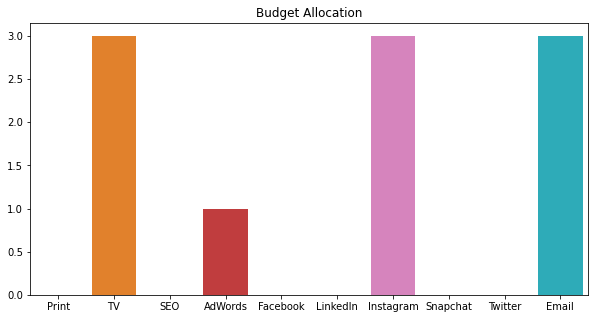

In [5]:
ojModel.optimize() # solve the LP
optimal_value_roi1  = ojModel.objVal
profit_1 = optimal_value_roi1 
budget_dict_roi1 = dict(pd.Series(data  = ojModX.x, index = channels))
#print("\nBudget Allocations are : ")
plt.figure(figsize = (10,5))
roi_1_allocation = list(ojModX.x) 
sn.barplot(y   = ojModX.x, x = channels)
plt.title("Budget Allocation" )
plt.show()

### 4)	Your boss is happy to see the promising results presented by the marketing department. However, your boss is also very concerned because your boss recalls being somewhat disappointed after following such recommendations in the past. To be cautious about the decision, your team has decided to get another opinion about the ROI data and rerun the analysis.  The second consulting firm returns the estimates of the ROI data in the table below (also in the CSV file mentioned above).  You are asked to compare the two optimal allocations from these two ROI estimates.  

In [6]:
obj = roi_2 # objective vector
A = np.zeros((13,10)) # initialize constraint matrix

############ Defining Constraints 
channel_level_cons = np.identity(10)
overall_budget_cons = np.ones((1,10))
A[11,[0,1]] = 1
A[11,[4,9]] = -1
A[12,4:9] = 1
A[12,2:4] = -2
A[0:10,] = channel_level_cons
A[10] = overall_budget_cons
##################################

#### Output Part of the constraint####
b = np.array([3,3,3,3,3,3,3,3,3,3,10,0,0]) 
sense = np.array(['<','<','<','<','<','<','<','<','<','<','<','<','>'])  

ojModel = gp.Model() # initialize an empty model

ojModX = ojModel.addMVar(10) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
ojModCon = ojModel.addMConstrs(A, ojModX, sense, b) # add the constraints to the model
ojModel.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

ojModel.Params.OutputFlag = 0 # tell gurobi to shut up!!

ojModel.optimize() # solve the LP
profit_2 = ojModel.objVal 
roi_2_allocation = list(ojModX.x)
budget_dict_roi2 = dict(pd.Series(data  = ojModX.x, index = channels))
#print("\nBudget Allocations are : ")
#budget_dict_roi2

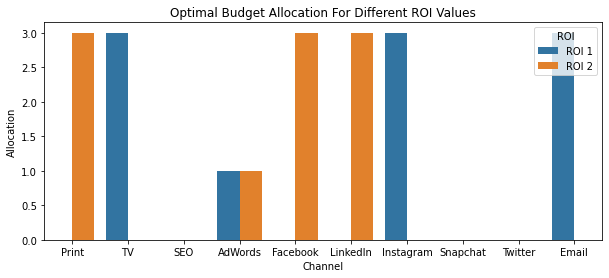

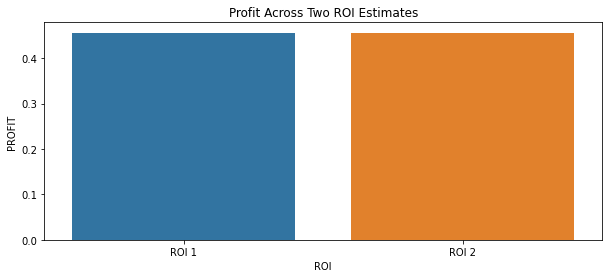

In [7]:
df = pd.DataFrame({
    'Channel': list(channels)*2,
    'ROI': ['ROI 1']*len(channels) +['ROI 2']*len(channels),
    'Allocation': roi_1_allocation+roi_2_allocation
})

plt.figure(figsize = (10,4))
sn.barplot(y = 'Allocation', x = 'Channel', hue = 'ROI', data = df)
plt.title("Optimal Budget Allocation For Different ROI Values")
plt.show()

df = pd.DataFrame({
    'ROI': ['ROI 1', 'ROI 2'],
    'PROFIT': [profit_1,profit_2]
})
plt.figure(figsize = (10,4))
sn.barplot(y = 'PROFIT', x = 'ROI', data = df)
plt.title("Profit Across Two ROI Estimates")
plt.show()

In [8]:
## Using ROI-1 based attribution on ROI-2
profit_a = sum(roi_1* np.array(list(budget_dict_roi2.values())))

print("When using ROI for first case and attribution for second, the change in obj function is {:.4f}".format(profit_a-ojModel.objVal))
## Using ROI-2 based attribution on ROI-1
profit_b = sum(roi_2* np.array(list(budget_dict_roi1.values())))
#print(np.round(profit_b-ojModel.objVal,2))
print("When using ROI for Second case and attribution for First, the change in obj function is {:.4f}".format(np.round(profit_b-ojModel.objVal,2)))


When using ROI for first case and attribution for second, the change in obj function is -0.2040
When using ROI for Second case and attribution for First, the change in obj function is -0.1900


### 5)	Are the allocations the same?  Assuming the first ROI data is correct, if you were to use the second allocation (the allocation that assumed the second ROI data was correct) how much lower would the objective be relative to the optimal objective (the one that uses the first ROI data and the first allocation)?  Assuming the second ROI data is correct, if you used the first allocation how much lower would the objective be relative to the optimal objective?  Do you think the third constraint above, based on your boss’ experience, is useful? 

* We can infer from the above graphs that the two allocations are not same.
* Answered in the output of chunk above
* Yes, the third constraint is useful because if the highest ROI channel is not restricted, the optimizer will put all the money in the most profitable channel. Having the budget allocation constrained at $3M, we can have a diversity in our marketing portfolio

### 6)	To explore this further perform some analysis of how your optimal allocation would change based on changes in the ROI data.  Use the first ROI data as your starting point.  By how much could each advertising medium’s ROI increase or decrease and still result in the same optimal allocation you found in step (3)?

Below code will help us find the sensitivity to allocation for input ROI matrix

In [9]:
def optimization_function(roi_matrix, flag=0):
    obj = roi_matrix # objective vector
    A = np.zeros((13,10)) # initialize constraint matrix

    ############ Defining Constraints 
    channel_level_cons = np.identity(10)
    overall_budget_cons = np.ones((1,10))
    A[11,[0,1]] = 1
    A[11,[4,9]] = -1
    A[12,4:9] = 1
    A[12,2:4] = -2
    A[0:10,] = channel_level_cons
    A[10] = overall_budget_cons
    ##################################

    #### Output Part of the constraint####
    b = np.array([3,3,3,3,3,3,3,3,3,3,10,0,0]) 
    sense = np.array(['<','<','<','<','<','<','<','<','<','<','<','<','>'])  

    ojModel = gp.Model() # initialize an empty model

    ojModX = ojModel.addMVar(10) # tell the model how many variables there are
    # must define the variables before adding constraints because variables go into the constraints
    ojModCon = ojModel.addMConstrs(A, ojModX, sense, b) # add the constraints to the model
    ojModel.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

    ojModel.Params.OutputFlag = 0 # tell gurobi to shut up!!

    ojModel.optimize() # solve the LP
    
    objective_value = ojModel.objVal
    budget_allocation = ojModX.x
    ret_values = np.append(budget_allocation,objective_value)
    ret_values = np.append(np.array(obj) , ret_values)
    
    if flag ==1:
        return ojModel.SAObjLow, ojModel.SAObjUp
        
    
    return ret_values

In [10]:
## Creating a dataframe that stores everything from ROI to Allocation and Objective value
df1 = pd.DataFrame(pd.Series(budget_dict_roi1)).T
df1.columns = ['ALLOCATION_'+ x for x in df1.columns]

df2 = pd.DataFrame(pd.Series(data = roi_1, index = list(budget_dict_roi1.keys()))).T
df2.columns = ['ROI_'+ x for x in df2.columns]


Text(0.5, 1.0, 'ROI Sensitivity Analysis : White in LB & UB indicates -inf & +inf respectively')

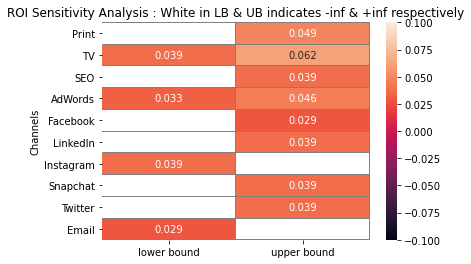

In [11]:
## Suppress depreciation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
###################################################################

roi_copy = roi_1.copy()
lower, upper = optimization_function(roi_copy, flag=1)
gb_sensitivity = pd.DataFrame([], columns = ['Channels','lower bound', 'upper bound']) 
gb_sensitivity['Channels'] = list(budget_dict_roi1.keys())
gb_sensitivity['lower bound'] = lower
gb_sensitivity['upper bound'] = upper
gb_sensitivity.set_index('Channels', drop=True, inplace = True)
sn.heatmap(gb_sensitivity, annot = True, linecolor = 'gray', linewidths = 0.1)
plt.title("ROI Sensitivity Analysis : White in LB & UB indicates -inf & +inf respectively" )

### 7)	Your boss has gained permission to reinvest half of the return. For example, if the marketing obtains a 4% return in January, the budget of February will be 10M USD + 10M × 4% × 50% = 10.2M USD.  The monthly ROI for next year is given in Project1.Rdata. The three constraints given by your boss are still in place for each month.  What is the optimal allocation for each month? 

In [12]:
def optimization_function_month(roi_matrix, budget):
    obj = roi_matrix # objective vector
    A = np.zeros((13,10)) # initialize constraint matrix

    ############ Defining Constraints 
    channel_level_cons = np.identity(10)
    overall_budget_cons = np.ones((1,10))
    A[11,[0,1]] = 1
    A[11,[4,9]] = -1
    A[12,4:9] = 1
    A[12,2:4] = -2
    A[0:10,] = channel_level_cons
    A[10] = overall_budget_cons
    ##################################

    #### Output Part of the constraint####
    b = np.array([3,3,3,3,3,3,3,3,3,3,budget,0,0]) 
    sense = np.array(['<','<','<','<','<','<','<','<','<','<','<','<','>'])  

    ojModel = gp.Model() # initialize an empty model

    ojModX = ojModel.addMVar(10) # tell the model how many variables there are
    # must define the variables before adding constraints because variables go into the constraints
    ojModCon = ojModel.addMConstrs(A, ojModX, sense, b) # add the constraints to the model
    ojModel.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

    ojModel.Params.OutputFlag = 0 # tell gurobi to shut up!!

    ojModel.optimize() # solve the LP
    
    objective_value = ojModel.objVal
    budget_allocation = ojModX.x
    
    return objective_value, budget_allocation

### Import the ROI matrix

In [13]:
monthly_roi = pd.read_csv("roi_mat.csv")
monthly_roi_clean = monthly_roi.drop(monthly_roi.columns[0], axis = 1)
monthly_roi_clean.head()

,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
0,4.0,3.6,2.4,3.9,3.0,3.5,3.6,2.25,3.5,3.5
1,4.0,3.9,2.7,3.8,4.3,3.2,2.7,1.80,3.7,3.5
2,3.5,2.9,3.1,3.8,2.4,4.1,3.7,2.60,4.2,2.5
3,3.8,3.1,2.4,4.4,2.4,3.8,3.7,2.50,3.6,2.9
4,3.5,3.2,1.9,3.4,2.7,2.7,3.9,2.20,4.5,3.9


- We  use the ROI shared by first consulting firm to optimally allocate the funds
- Then, we use the actual monthly ROI to calculate the profit per channel

In [14]:
budget = 10
previous_allocation = np.zeros(10)
month_iter = 0
channels = list(channels)
channels.append('Month')
DeltaBudgetAllocation = list([])
empty_df  = pd.DataFrame([], columns = channels)
budget_list = []

for x in ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']:
    roi_month = np.array(monthly_roi_clean.loc[month_iter,:])/100 
    forecasted_profit, budget_allocation_based_on_forecast_ROI = optimization_function_month(roi_1,budget)
    roi_month_df  = pd.DataFrame([], columns =channels )
    roi_month_df.loc['Budget Allocation',:] = list(np.round(budget_allocation_based_on_forecast_ROI,2))+[x]
    DeltaBudgetAllocation.append(list(np.round(budget_allocation_based_on_forecast_ROI - previous_allocation,2)))
    profit_monthly = np.sum(np.round(budget_allocation_based_on_forecast_ROI,2)*roi_month)
    roi_month_df 
    previous_allocation = budget_allocation_based_on_forecast_ROI
    month_iter= month_iter+1
    budget = budget + 0.5*profit_monthly
    budget_list.append(budget)
    empty_df = pd.concat([empty_df, roi_month_df], ignore_index=True)

Below is the summary of monthly allocation of budget for each channel 

In [15]:
allocation_df = empty_df.set_index(['Month'], drop = True)
allocation_df.T

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Print,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TV,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
SEO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AdWords,1.0,1.18,1.35,1.51,1.56,1.63,1.7,1.77,1.85,1.91,1.97,2.05
Facebook,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LinkedIn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Instagram,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
Snapchat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Twitter,0.0,0.0,0.0,0.01,0.13,0.26,0.4,0.55,0.69,0.82,0.95,1.1
Email,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


# 8)	A stable budget is defined as a monthly allocation such that for each platform the monthly change in spend is no more than 1M USD. Is the allocation you found stable? If it isn’t, you do not need to solve a new optimization model.  Describe how my might model this?

From the above table,  we observe that it is a stable allocation. If it was unstable, we will add one additional constraint for each channel indicating that the difference in the consecutive months should be no more than 1M for each channel. 